In [33]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [34]:
from sm_funcs import get_spectral_type
import sm_funcs


We have to simulation the stars and the planets that orbit those stars, so first we are going to make up a population of stars.

The first thing to do is to get all the stars observed by Kepler, we can get this from the MAST.
Then load the masses and then assign a one or fewer binary companions. Binary distributions is Raghavan et al. 2010.



In [35]:
keplerstellar = pd.read_csv('../data/kepler_stellar17.csv.gz', delimiter='|')
allquarters = keplerstellar.st_quarters == 11111111111111111
isGoodData = np.isfinite(keplerstellar.mass) * (keplerstellar.st_radius < 3.5)

In [36]:
# from Raghavan et al. 2010

# orbital period distribution
logPeriod = np.random.normal(5.03,2.28, size=keplerstellar.shape[0])

#for OBAFMKMLT
binaryProbability = {'O': 0.75, 
                      'B': 0.70, 
                      'A': 0.70, 
                      'F': 0.50,
                      'G': 0.41,
                      'K': 0.41,
                      'M': 0.35,
                      'L': 0.20,
                      'T': 0.20,
                      }

# mass ratio can be approximated by a uniform
# but it may be better estimated by distribution that increases toward higher number
# so I'll use uniform in (e - e^(x)) / (e - 1)
massRatio = (np.e-np.e**(np.random.uniform(size=keplerstellar.shape[0]))) / (np.e-1.0)
compMass = keplerstellar.mass * massRatio

Now we need to go through the catalog and assign a binary companion

In [37]:
# let's make some new columns that we'll need

stype_arr = np.empty(keplerstellar.shape[0], dtype='str')
isBinary_arr = np.empty(keplerstellar.shape[0], dtype='bool')

for idx in tqdm(range(keplerstellar.shape[0])):
    stype = get_spectral_type(keplerstellar['teff'][idx])
    stype_arr[idx] = stype
    isBinary_arr[idx] = binaryProbability[stype]  <  np.random.uniform()




100%|██████████| 200038/200038 [00:06<00:00, 32182.47it/s]


In [38]:
# which star should the planet orbit
# we'll say it's 50/50 unless the companion is an M-dwarf
# let's say that the max mass of an M-dwarf is 0.55 Msun
# and let's say that if it's an M-dwarf, the probability the planet's around a companion is 2.5/0.689

orbitProb = np.where(compMass<=0.55, 1. - (0.689/2.5), 0.5)
orbitsPrimary = np.where(np.random.uniform(size=keplerstellar.shape[0]) > orbitProb, True, False)


In [39]:
# it's a factor of a few hundred times faster to loop and add to the dataframe
keplerstellar['stype'] = stype_arr
keplerstellar['isBinary'] = isBinary_arr
keplerstellar['massRatio'] = massRatio
keplerstellar['period'] = np.e**logPeriod
keplerstellar['compMass'] = compMass
keplerstellar['orbitsPrimary'] = orbitsPrimary
keplerstellar['hostMass'] = np.where((isBinary_arr & orbitsPrimary) | ~isBinary_arr, 
                                     keplerstellar.mass, compMass)

In [40]:
# now let's make an array that excludes things we don't want
q = keplerstellar[allquarters & isGoodData]

OK, now we need to start putting planets around these stars. We're going to use Fressin's catalog for all stars except M-dwarfs and use Dressing's number for M-dwarfs. 

For the time being we are going to make the assumption that every star has a planet

In [41]:
#some parameters we will need later

# let's make them all transit
# q.loc[:,'cosi'] = pd.Series(np.random.random(size=q.shape[0]),name='cosi')
mag = q.loc[:,'kepmag']
q.loc[:,'noise_level'] = sm_funcs.kepler_noise_6h(mag) * np.sqrt(6)


In [45]:
# add planets
# first draw planets

mdwarfplanets = sm_funcs.Dressing15_select(q.shape[0])
otherplanets = sm_funcs.Fressin13_select(q.shape[0])

[planetRadius, planetPeriod] = np.where((q.stype == 'M') | ((q.compMass <=0.55) & q.isBinary), mdwarfplanets, otherplanets )



In [46]:
q.loc[:,'planetRadius'] = planetRadius
q.loc[:,'planetPeriod'] = planetPeriod
q.loc[:,'rprs'] = sm_funcs.get_rprs(planetRadius, q.hostMass)
q.loc[:, 'ars'] = sm_funcs.per2ars(planetPeriod, q.mass, q.hostMass)

# need a fudge here to stop a/r* < 1
q.loc[:, 'ars'] = np.where(q.loc[:, 'ars'] < 1.0, 1.01, q.loc[:, 'ars'])

q.loc[:, 'duration'] = sm_funcs.get_duration(planetPeriod, q.ars, rprs=q.rprs)

In [47]:
q.loc[:,'duration_correction'] = np.sqrt(q.duration * 24.) # correction for CDPP because transit dur != 1 hour
q['transit_depth_undiluted']  = sm_funcs.get_transit_depth(q.planetRadius, q.hostMass)

/Users/tom/.virtualenvs/p2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


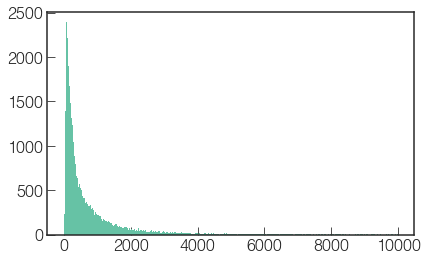

In [53]:
q['transit_depth_diluted'] = 

In [37]:
def powerlaw(x,a,b,c):
    return a*(x**b)+c

In [38]:
kp_pars = [8.99783121e-12,   1.10726939e+01,   1.06404927e+01]

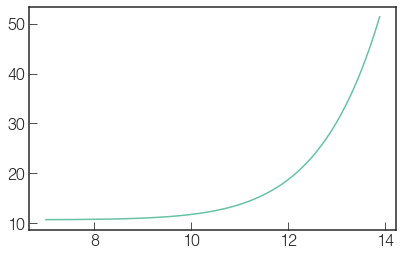

In [43]:
x = np.arange(7,14,0.1)
plt.plot(x, powerlaw(x, *kp_pars))


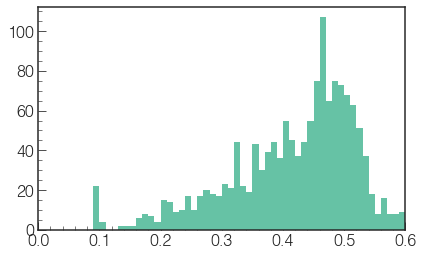

In [35]:
bins = np.arange(0,2,0.01)


#plt.hist(q.mass[q.stype != 'M'], bins = bins)
plt.hist(q.mass[q.stype == 'M'], bins = bins)

plt.xlim(0,0.6)
plt.minorticks_on()

In [52]:
orbitProb[2], orbitsPrimary[2]

(0.72440000000000004, True)

In [34]:
q.columns

Index([u'kepid', u'tm_designation', u'teff', u'teff_err1', u'teff_err2',
       u'logg', u'logg_err1', u'logg_err2', u'feh', u'feh_err1', u'feh_err2',
       u'mass', u'mass_err1', u'mass_err2', u'st_radius', u'radius_err1',
       u'radius_err2', u'dens', u'dens_err1', u'dens_err2', u'prov_sec',
       u'kepmag', u'dist', u'dist_err1', u'dist_err2', u'nconfp', u'nkoi',
       u'ntce', u'datalink_dvr', u'st_delivname', u'st_vet_date_str',
       u'degree_ra', u'degree_dec', u'st_quarters', u'teff_prov', u'logg_prov',
       u'feh_prov', u'jmag', u'jmag_err', u'hmag', u'hmag_err', u'kmag',
       u'kmag_err', u'dutycycle', u'dataspan', u'mesthres01p5',
       u'mesthres02p0', u'mesthres02p5', u'mesthres03p0', u'mesthres03p5',
       u'mesthres04p5', u'mesthres05p0', u'mesthres06p0', u'mesthres07p5',
       u'mesthres09p0', u'mesthres10p5', u'mesthres12p0', u'mesthres12p5',
       u'mesthres15p0', u'rrmscdpp01p5', u'rrmscdpp02p0', u'rrmscdpp02p5',
       u'rrmscdpp03p0', u'rrmscdpp03p5',

In [36]:
q.duration

0         None
1         None
2         None
3         None
4         None
5         None
6         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
17        None
20        None
22        None
23        None
26        None
28        None
29        None
30        None
31        None
35        None
36        None
38        None
39        None
42        None
43        None
          ... 
199944    None
199945    None
199946    None
199947    None
199948    None
199949    None
199950    None
199951    None
199952    None
199953    None
199955    None
199956    None
199957    None
199958    None
199960    None
199961    None
199963    None
199964    None
199966    None
199967    None
199969    None
199971    None
199972    None
199973    None
199976    None
199977    None
199978    None
199984    None
199985    None
199986    None
Name: duration, dtype: object

ValueError: max must be larger than min in range parameter.

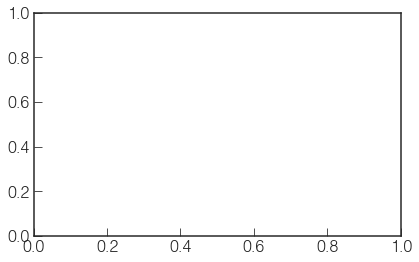

In [32]:
plt.hist(keplerstellar['hostMass'])